# IHLT - LABORATORY 7
Armando Rodriguez Ramos and Yara Yousef

## Import the necessary packages

In [1]:
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.8 MB/s 


In [2]:
import nltk
import spacy
import pandas as pd
from scipy.stats import pearsonr
from nltk.metrics import jaccard_distance
from nltk.stem import WordNetLemmatizer
import svgling
from nltk.corpus import conll2000
from nltk import tree2conlltags

In [3]:
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
armandPath = '/content/drive/My Drive/UNIVERSITAT/Master/1-1/IHLT/LabsIHLT/Lab7/Data/'
yaraPath = '/content/drive/My Drive/Labs/IHLT/Lab7/Data/'
path = armandPath
dtOriginal = pd.read_csv(path+'STS.input.SMTeuroparl.txt',sep='\t',header=None)
dtOriginal['gs'] = pd.read_csv(path+'STS.gs.SMTeuroparl.txt',sep='\t',header=None)
dtOriginal.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  
0  The leaders benefit aujourd' hui of a new luck...  4.50  
1  Amendment No 7 is proposing certain changes in...  5.00  
2  I would like to remind you that among our alli...  4.25  
3                 The vote will take place at 5.30pm  4.50  
4  The fishermen are inactive, tired and disappoi...  5.00

## Compare NLTK and SpaCy lemmatizers

### NLTK lemmatizer (code from laboratory 3)

#### Define functions to lemmatize

The first of two functions here removes stopwords and punctuations. The second creates the (word,tag) pair, applies the beautifyTokensTag() function to that pair, renames the tags of interest, applies the wnl lemmatize() function to the words, and returns the lemmatized words as a set.

In [7]:
stopWords = set(nltk.corpus.stopwords.words('english'))

def beautifyTokensTag(listTokensTag):
  return [(word,tag) for word,tag in listTokensTag if (word.lower() not in stopWords) and (word.isalnum())]

def lemmatizeWordsNLTK(wordsIn):
  lemmatizedWordsList = []

  pairs = nltk.pos_tag(wordsIn)

  pairsBeauty = beautifyTokensTag(pairs)

  for word, tag in pairsBeauty:
    lemmatizedWord = word.lower()
    tagLowered = tag.lower()

    # Noun ==> N,  Verbs ==> V    
    pos = tagLowered[0]
    if pos == 'j': pos = 'a' # Adjective = J ==> A
    if tagLowered[:2] == 'rb': pos = 'r' # Adverb = RB ==> R

    wnl = WordNetLemmatizer()
    if pos in ['n','v','a','r']:
      lemmatizedWord = wnl.lemmatize(lemmatizedWord, pos=pos)

    lemmatizedWordsList.append(lemmatizedWord)

  return set(lemmatizedWordsList)

#### Apply and compute correlation

In [8]:
dtLemmaNLTK = dtOriginal.copy()
dtLemmaNLTK['tokensLemmaNLTK0'] = dtLemmaNLTK.apply(lambda row: lemmatizeWordsNLTK(nltk.word_tokenize(row[0])),axis=1)
dtLemmaNLTK['tokensLemmaNLTK1'] = dtLemmaNLTK.apply(lambda row: lemmatizeWordsNLTK(nltk.word_tokenize(row[1])),axis=1)
dtLemmaNLTK['jaccardLemmaNLTK'] = dtLemmaNLTK.apply(lambda row: 1-jaccard_distance(row['tokensLemmaNLTK0'],row['tokensLemmaNLTK1']),axis=1)
dtLemmaNLTK.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  \
0  The leaders benefit aujourd' hui of a new luck...  4.50   
1  Amendment No 7 is proposing certain changes in...  5.00   
2  I would like to remind you that among our alli...  4.25   
3                 The vote will take place at 5.30pm  4.50   
4  The fishermen are inactive, tired and disappoi...  5.00   

                                    tokensLemmaNLTK0  \
0  {new, seize, chance, hope, let, leader, us, give}   
1  {paragraph, reference, 7, change, certain, pro...   
2  {ally, tax, remind, let, supporter, fervent, i...   
3                         {today, place, take, vote}   
4         {tired, fisherman, disappointed, inactive}   

                                    tokensLemmaNLTK1  jaccardLemmaNLTK  
0  {new, aujourd, seize, luck, benefit, therefore...          0.307692  
1  {paragraph, reference, 7, change, certain, pro...          1.000000  
2    {ally, like, would, strong, among, tax, remind}          0.272727  
3                                {place, take, vote}          0.750000  
4         {tired, fisherman, disappointed, inactive}          1.000000

In [9]:
corrLemmaNLTK = pearsonr(dtLemmaNLTK['gs'], dtLemmaNLTK['jaccardLemmaNLTK'])[0]*100
print("Pearson correlation coefficient with NLTK lemmatizer =", round(corrLemmaNLTK,3), "%")

Pearson correlation coefficient with NLTK lemmatizer = 49.929 %


### SpaCy lemmatizer (following the same method as above for comparison with NLTK)

#### Define lemmatize function

Here, we only have one function not because we are not applying the preprocessing done with the beautifyTokensTag() function, but because we are using the built-in functions from SpaCy to do so; by applying `if not (token.is_stop or token.pos_=='PUNCT')` in the loop, we are removing stopwords and punctuation.

So in all, this function reduces the list of words to those of interest and lemmatizes them, using entirely SpaCy functions. Note that SpaCy's lemmatize function already includes POS tagging as part of its process.

A quick word about the nlp() function: the nlp is a trained pipeline, and calling it returns a Language object that has all the components and data required to process our text. When we call this object on the desired text using the function nlp(), this is processing the text into tokens for further use with the other SpaCy functions, or for just accessing the different variables as we do here.

In [10]:
def lemmatizeWordsSpaCy(sentence):
  lemmatizedWordsList = []

  doc = nlp(sentence)
  lemmatizedWordsList = [(token.lemma_.lower()) for token in doc
                         if not (token.is_stop or token.pos_=='PUNCT')]

  return set(lemmatizedWordsList)

#### Apply and compute correlation

In [11]:
dtLemmaSpaCy = dtOriginal.copy()
dtLemmaSpaCy['tokensLemmaSpaCy0'] = dtLemmaSpaCy.apply(lambda row: lemmatizeWordsSpaCy(row[0]),axis=1)
dtLemmaSpaCy['tokensLemmaSpaCy1'] = dtLemmaSpaCy.apply(lambda row: lemmatizeWordsSpaCy(row[1]),axis=1)
dtLemmaSpaCy['jaccardLemmaSpaCy'] = dtLemmaSpaCy.apply(lambda row: 1-jaccard_distance(row['tokensLemmaSpaCy0'],row['tokensLemmaSpaCy1']),axis=1)
dtLemmaSpaCy.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  \
0  The leaders benefit aujourd' hui of a new luck...  4.50   
1  Amendment No 7 is proposing certain changes in...  5.00   
2  I would like to remind you that among our alli...  4.25   
3                 The vote will take place at 5.30pm  4.50   
4  The fishermen are inactive, tired and disappoi...  5.00   

                                   tokensLemmaSpaCy0  \
0      {new, seize, chance, hope, let, leader, give}   
1  {paragraph, reference, 7, change, certain, pro...   
2  {ally, tax, remind, let, supporter, fervent, i...   
3                   {place, vote, today, p.m., 5.30}   
4         {tired, fisherman, disappointed, inactive}   

                                   tokensLemmaSpaCy1  jaccardLemmaSpaCy  
0  {new, aujourd, seize, ', luck, benefit, let, l...           0.333333  
1  {paragraph, reference, 7, change, certain, pro...           1.000000  
2                  {ally, like, strong, tax, remind}           0.333333  
3                              {place, 5.30pm, vote}           0.333333  
4         {tired, fisherman, disappointed, inactive}           1.000000

In [12]:
corrLemmaSpaCy = pearsonr(dtLemmaSpaCy['gs'], dtLemmaSpaCy['jaccardLemmaSpaCy'])[0]*100
print("Pearson correlation coefficient with SpaCy lemmatizer =", round(corrLemmaSpaCy,3), "%")

Pearson correlation coefficient with SpaCy lemmatizer = 51.768 %


### Lemmatizers comparison

In [13]:
print("Pearson correlation coefficient with NLTK lemmatizer =", round(corrLemmaNLTK,3), "%")
print("Pearson correlation coefficient with SpaCy lemmatizer =", round(corrLemmaSpaCy,3), "%")

Pearson correlation coefficient with NLTK lemmatizer = 49.929 %
Pearson correlation coefficient with SpaCy lemmatizer = 51.768 %


We find that using SpaCy functions results in a nearly 2% increase of the pearson correlation.

This is likely because the SpaCy functions overall perform better in identifying the most important words of the sentence that summarize and describe its meaning. We will look more closely at the sentences in rows 0 and 2 as examples:

> In row 0, we see that for both sentences, the NLTK functions left one more word as a word of interest. In the first sentence, it left the word "us". In the second, it left the word "therefore". SpaCy, however, removes these words, which is a good thing to do because neither adds much to the overall meaning of the sentences, and they shouldn't count as a point of difference betweeen the two. Removing them results in a slight similarity increase from 0.31 with NLTK to 0.33 with SpaCy.

> In row 2, the first sentence's tokens are unchanged between NLTK and SpaCy, however for the second, the SpaCy functions remove the words "would" and "among". This is also a good thing, again because these words contribute no real meaning to the overall point of the sentence. In removing them, the similarity increases from 0.27 with NLTK to 0.33 with SpaCy.


All this said, we also observe that there are some sentences in this particular implementation for which SpaCy performs worse than NLTK. We will look more closely at the sentences in row 3 as an example:

> With NLTK functions, we note that the actual time of the vote (5:30pm) is not kept as a meaningful word. We will come back to this later. SpaCy does not keep the word "take" like NLTK does, which again similarly to the examples above, make sense as this word does not affect the overall sentence meaning of there being a vote. Moreover, SpaCy does keep the time of the vote, but this is where the similarity measure goes wrong. In the first sentence, there is a space between "5:30" and "p.m.", so they are counted as two separate words, whereas in the second sentence they are kept toegther and counted as one word. Hence, this implementation of SpaCy functions result in these extremely similar sentences having a similarity of only 0.33, whereas with NLTK functions they are found to have a more adequate similarity measure of 0.75.

While it would be better to take the actual time into account to be sure the sentence meanings are the same, so this is more a situation where NLTK just so happened to be correct, it is still worth noting that with SpaCy, these sentences had a significantly lower similarity measure than they should. A potential solution would be putting times and descriptions like "p.m" together, the way first and last names are put together in the following section.

## Name entities with SpaCy (laboratory 7)

### Using the name entity text

Below, we define a function similar to the lemmatizeWordsSpaCy() function from the section above; we still use the nlp() Language object to process the test, and remove stopwords and punctuations.

However, here we first combine name entities into one since having them separate could unecessarily affect the similarity measures between sentences. For example, instead of the name John Smith returning two tokens "John" and "Smith", we merge them and retrieve the singular name token "John Smith". Similarly for company names, so on and so forth.

Here, we are also returning a list of texts rather than a list of lemmas.\
token.text returns verbatim text content as a string, it's simply the actual text of the doc. So here, we will be calculating a jaccard distance value using this text instead of the usual lemmas.

In [14]:
def nameEntitiesTextSpaCy(sentence):
  doc = nlp(sentence)
  with doc.retokenize() as retokenizer:
    tokens = [token for token in doc]
    for ent in doc.ents:
      retokenizer.merge(doc[ent.start:ent.end], 
                        attrs={"LEMMA": " ".join([tokens[i].text for i in range(ent.start, ent.end)])})
  texts = [((token.text).lower()) for token in doc if not (token.is_stop or token.pos_=='PUNCT')]
  return texts

In [15]:
dtEntitiesTextSpaCy = dtOriginal.copy()
dtEntitiesTextSpaCy['tokensNETextSpacy0'] = dtEntitiesTextSpaCy.apply(lambda row: set(nameEntitiesTextSpaCy(row[0])),axis=1)
dtEntitiesTextSpaCy['tokensNETextSpacy1'] = dtEntitiesTextSpaCy.apply(lambda row: set(nameEntitiesTextSpaCy(row[1])),axis=1)
dtEntitiesTextSpaCy['jaccardNETextSpaCy'] = dtEntitiesTextSpaCy.apply(lambda row: 1-jaccard_distance(row['tokensNETextSpacy0'],row['tokensNETextSpacy1']),axis=1)
dtEntitiesTextSpaCy.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  \
0  The leaders benefit aujourd' hui of a new luck...  4.50   
1  Amendment No 7 is proposing certain changes in...  5.00   
2  I would like to remind you that among our alli...  4.25   
3                 The vote will take place at 5.30pm  4.50   
4  The fishermen are inactive, tired and disappoi...  5.00   

                                  tokensNETextSpacy0  \
0    {new, seize, chance, hope, leaders, let, given}   
1  {paragraphs, changes, references, 7, certain, ...   
2  {supporters, tax, allies, remind, let, fervent...   
3                    {5.30 p.m., place, today, vote}   
4         {inactive, tired, disappointed, fishermen}   

                                  tokensNETextSpacy1  jaccardNETextSpaCy  
0  {new, aujourd, seize, ', luck, benefit, leader...            0.333333  
1  {paragraphs, changes, references, 7, certain, ...            0.750000  
2                {like, strong, tax, allies, remind}            0.333333  
3                              {place, 5.30pm, vote}            0.400000  
4         {inactive, tired, disappointed, fishermen}            1.000000

In [16]:
corrNETextSpaCy = pearsonr(dtEntitiesTextSpaCy['gs'], dtEntitiesTextSpaCy['jaccardNETextSpaCy'])[0]*100
print("Pearson correlation coefficient with SpaCy name entities text =", round(corrNETextSpaCy,3), "%")

Pearson correlation coefficient with SpaCy name entities text = 46.46 %


We see a pearson correlation about five percent lower than what was achieved in the last section, which is unsurprising considering that the words we are comparing have little processing: they have not been reduced to their lemmas, so there will be "differences" found that are not really there.

One notable increase however, is seen in the sentences of row 3. This is because where in the last section for the first sentence "5:30" and "p.m." were two separate tokens, they are now merged into one "5:30 p.m." token, and we see an increase in similiarty from 0.33 to 0.4 as a result.

(We note however that this is still quite low for two sentences that are so similar; for the project more work could be done to ensure that tokens like "5:30 p.m." and "5:30pm" will be recognized to have the same meaning regardless of the insignificant differences.)

### Using the name entity type

In [17]:
def nameEntitiesTypeSpaCy(sentence):
  doc = nlp(sentence)
  with doc.retokenize() as retokenizer:
    tokens = [token for token in doc]
    for ent in doc.ents:
      retokenizer.merge(doc[ent.start:ent.end], 
                        attrs={"LEMMA": " ".join([tokens[i].text for i in range(ent.start, ent.end)])})
  types = [(token.ent_type_) for token in doc if not (token.is_stop or token.pos_=='PUNCT')]
  return types

In [18]:
dtEntitiesTypeSpaCy = dtOriginal.copy()
dtEntitiesTypeSpaCy['tokensNETypeSpacy0'] = dtEntitiesTypeSpaCy.apply(lambda row: set(nameEntitiesTypeSpaCy(row[0])),axis=1)
dtEntitiesTypeSpaCy['tokensNETypeSpacy1'] = dtEntitiesTypeSpaCy.apply(lambda row: set(nameEntitiesTypeSpaCy(row[1])),axis=1)
dtEntitiesTypeSpaCy['jaccardNETypeSpaCy'] = dtEntitiesTypeSpaCy.apply(lambda row: 1-jaccard_distance(row['tokensNETypeSpacy0'],row['tokensNETypeSpacy1']),axis=1)
dtEntitiesTypeSpaCy.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs tokensNETypeSpacy0  \
0  The leaders benefit aujourd' hui of a new luck...  4.50                 {}   
1  Amendment No 7 is proposing certain changes in...  5.00                 {}   
2  I would like to remind you that among our alli...  4.25                 {}   
3                 The vote will take place at 5.30pm  4.50     {, TIME, DATE}   
4  The fishermen are inactive, tired and disappoi...  5.00                 {}   

  tokensNETypeSpacy1  jaccardNETypeSpaCy  
0                 {}            1.000000  
1                 {}            1.000000  
2                 {}            1.000000  
3                 {}            0.333333  
4                 {}            1.000000

In [19]:
corrNETypeSpaCy = pearsonr(dtEntitiesTypeSpaCy['gs'], dtEntitiesTypeSpaCy['jaccardNETypeSpaCy'])[0]*100
print("Pearson correlation coefficient with SpaCy name entities type =", round(corrNETypeSpaCy,3), "%")

Pearson correlation coefficient with SpaCy name entities type = 8.875 %


Since we have very few name entities, or at least name entities that the functions can recognize (for example, we see that in the first five rows the only recognized name entity is the {DATE, TIME} one for the first sentence of row 3), trying to compare these particular sentences by name entity type doesn't make any sense.

### Name entities comparison

In [20]:
print("Pearson correlation coefficient with SpaCy name entities text =", round(corrNETextSpaCy,3), "%")
print("Pearson correlation coefficient with SpaCy name entities type =", round(corrNETypeSpaCy,3), "%")

Pearson correlation coefficient with SpaCy name entities text = 46.46 %
Pearson correlation coefficient with SpaCy name entities type = 8.875 %


We clearly see here that, with the current implementation, comparison using the name entities' type is not feasible. This is the lowest value we have gotten across all the labs up to now.

Comparison using the name entities text clearly does better, however it still performs significantly lower than our previous method (reducing to lemmas).

### Analysis and Conclusions

Here, we have performed comparisons using four different methods:

1. NLTK functions with text pre-processing that included reduction to lemmas
2. SpaCy functions with text pre-processing that included reduction to lemmas
3. SpaCy functions with name entities text comparison (which *did not* include reduction to lemmas)
4. SpaCy functions with name entities type comparison

The worst of these performances by far was seen with the last one, since these particular sentences do not have many name entities and the functions were not able to recognize many of the ones that were there.

While comparison with name entities' text performed better, many false differences were found when computing the jaccard distance due to things like singular vs plural nouns, etc. We did, however, also find that the merging of names, times, etc. yielded better results.

Overall, we conclude that SpaCy functins perform better than the NLTK ones and that lemmatizing works better than using name entities. The next step will be to implement this in the project using the aforementioned conclusions, including mergings.

# Optional Exercise

We created our grammar to be able to create a parser that correctly parses the example sentence.

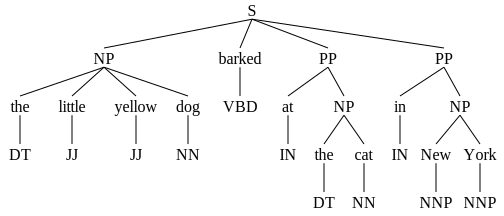

In [47]:
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),("dog", "NN"),\
 ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN"), \
 ("in", "IN"), ("New", "NNP"), ("York", "NNP")]

grammar = r"""NP: {<DT>?<JJ>*(<NN>|<NNP>)+}
              PP: {<IN><NP>}"""

cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
svgling.draw_tree(result)

Then we used this parser in order to get the evaluation results for the conll2000 corpus.

In [52]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  65.7%%
    Precision:     39.7%%
    Recall:        27.0%%
    F-Measure:     32.1%%


We can see that we obtained better results than the ones obtained with the previous parser in the example notebook. It is also important to note that, even if the accuracy, recall and f-mesure are better, the precision is lower in this scenerario.

Then we will get an example sentence with "NP" chunk to see how well our parser works. We also noticed that using both "NP" and "PP" chunks didn't alter the resulting tree we can see below.

Example tree:
 (S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


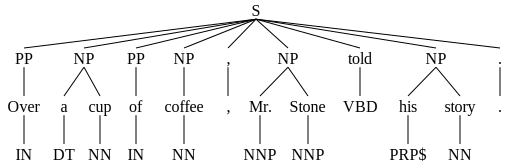

In [56]:
sentenceTree = conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99]
print("Example tree:\n",sentenceTree)
svgling.draw_tree(sentenceTree)

Now we use the "tree2conlltags" function to convert the tree to a list of words-tag and be able to pass it through our parser.

In [57]:
word_Tag = tree2conlltags(sentenceTree)
newSentence = [(word,tag) for (word,tag,_) in word_Tag]

Example sentence and its tree:
 (S
  (PP Over/IN (NP a/DT cup/NN))
  (PP of/IN (NP coffee/NN))
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  his/PRP$
  (NP story/NN)
  ./.)


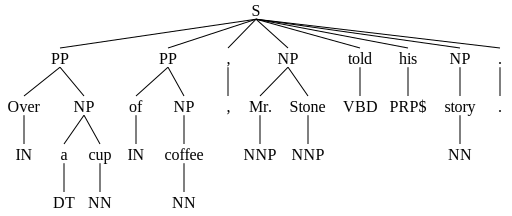

In [58]:
result = cp.parse(newSentence)
print("Example sentence and its tree:\n",result)
svgling.draw_tree(result)

We can see that we have some PP's correctly parsed with different NP's across the sentence each one with a different and totally valid structure.